In [2]:
from copy import deepcopy as copy

import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import os
import datetime as dt
import random
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import datetime


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

%matplotlib inline 

In [3]:
def load_data(company, start, end):
    data = web.DataReader(company, 'yahoo', start, end)
    return data

In [4]:
company = 'PFE'

In [5]:
df_cboe=  pd.read_csv('./cboe.csv')
df_cboe['Date']=df_cboe['Date'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y").strftime("%Y-%m-%d"))
df_cboe=df_cboe.dropna()
display(df_cboe)

,Date,VIX Open,VIX High,VIX Low,VIX Close
0,2004-01-02,17.96,18.68,17.54,18.22
1,2004-01-05,18.45,18.49,17.44,17.49
2,2004-01-06,17.66,17.67,16.19,16.73
3,2004-01-07,16.72,16.75,15.50,15.50
4,2004-01-08,15.42,15.68,15.32,15.61
...,...,...,...,...,...
3532,2018-01-12,9.74,10.31,9.54,10.16
3533,2018-01-16,10.42,12.41,10.40,11.66
3534,2018-01-17,11.35,12.81,11.18,11.91
3535,2018-01-18,12.01,12.40,11.62,12.22


In [6]:
data = load_data(company = company,
                 start = dt.datetime(1972,1,1),
                 end = dt.datetime(2020,1,1))
display(data)
# data=data.dropna()
# import os


# data =pd.read_csv('./Stocks/pfe.us.txt')
# data.shape
# display(data)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1972-06-01,0.815346,0.802993,0.000000,0.815346,2458771.0,0.187400
1972-06-02,0.817817,0.802993,0.815346,0.805463,1613885.0,0.185129
1972-06-05,0.807934,0.798051,0.805463,0.802993,2585251.0,0.184561
1972-06-06,0.825229,0.800522,0.802993,0.820288,2347469.0,0.188536
1972-06-07,0.820288,0.807934,0.820288,0.820288,1032077.0,0.188536
...,...,...,...,...,...,...
2019-12-24,37.419353,37.191650,37.314991,37.277039,5187683.0,35.428619
2019-12-26,37.542694,37.191650,37.286530,37.362431,9384078.0,35.509777
2019-12-27,37.590134,37.239090,37.409866,37.305504,10117662.0,35.455673


In [8]:
# data = pd.merge(data, df_cboe, how='inner')
# display(data)

In [9]:
data = data.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(data)),columns=['Close', 'Volume'])
for i in range(0,len(data)):
    new_data['Close'][i] = data['Close'][i]
    new_data['Volume'][i] = data['Volume'][i]
new_data.dropna()
    
display(new_data)

,Close,Volume
0,0.815346,2458771.0
1,0.805463,1613885.0
2,0.802993,2585251.0
3,0.820288,2347469.0
4,0.820288,1032077.0
...,...,...
11996,37.277039,5187683.0
11997,37.362431,9384078.0
11998,37.305504,10117662.0
11999,36.916508,11554264.0


In [10]:
scaler = MinMaxScaler(feature_range=(0,1))

In [11]:
df_sc = scaler.fit_transform(new_data.values)
display(df_sc)
df_sc.shape

array([[0.0082445 , 0.00805147],
       [0.00803444, 0.00528481],
       [0.00798195, 0.00846564],
       ...,
       [0.78379877, 0.03313121],
       [0.77553113, 0.03783549],
       [0.78097568, 0.04969422]])

(12001, 2)

In [12]:
train_end=int(len(df_sc)*.6)
val_end = train_end+int(len(df_sc)*.2)


In [13]:
un_train_df= new_data[:train_end].values
# un_train_df.shape
train_df = df_sc[:train_end]
# train_df.shape
un_train_df.shape

(7200, 2)

In [14]:
un_val_df= new_data[train_end:val_end].values
val_df = df_sc[train_end:val_end]
val_df.shape

(2400, 2)

In [15]:
un_test_df= new_data[val_end:].values
test_df = df_sc[val_end:]
un_test_df.shape

(2401, 2)

In [16]:
window = 30

In [17]:
def prepData(scaled_data, unscaled, window):
    x_train = []
    y_train = []

    for x in range(window, len(scaled_data)):
        x_train.append(scaled_data[x - window:x])
        y_train.append(unscaled[x,0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],2))
    print(x_train.shape)
    print(y_train.shape)
    return x_train, y_train

In [18]:

x_train, y_train = prepData(train_df, un_train_df, window)
display(x_train)
display(y_train)

(7170, 30, 2)
(7170,)


array([[[0.0082445 , 0.00805147],
        [0.00803444, 0.00528481],
        [0.00798195, 0.00846564],
        ...,
        [0.00976737, 0.00715686],
        [0.00981989, 0.00883011],
        [0.00929475, 0.0036447 ]],

       [[0.00803444, 0.00528481],
        [0.00798195, 0.00846564],
        [0.00834953, 0.007687  ],
        ...,
        [0.00981989, 0.00883011],
        [0.00929475, 0.0036447 ],
        [0.00971485, 0.00518541]],

       [[0.00798195, 0.00846564],
        [0.00834953, 0.007687  ],
        [0.00834953, 0.00337963],
        ...,
        [0.00929475, 0.0036447 ],
        [0.00971485, 0.00518541],
        [0.00955732, 0.00268382]],

       ...,

       [[0.89077351, 0.05321156],
        [0.85044373, 0.04404356],
        [0.87186892, 0.03131714],
        ...,
        [0.85800552, 0.02955795],
        [0.86808799, 0.02277591],
        [0.85800552, 0.03251099]],

       [[0.85044373, 0.04404356],
        [0.87186892, 0.03131714],
        [0.89707504, 0.0453872 ],
        .

array([ 0.88452703,  0.87711501,  0.86723202, ..., 40.14468765,
       42.57590103, 42.69449615])

In [20]:
x_val, y_val = prepData(val_df,un_val_df, window)
display(x_val)

(2370, 30, 2)
(2370,)


array([[[0.91093836, 0.05159181],
        [0.88447198, 0.05955976],
        [0.86808799, 0.06070045],
        ...,
        [0.86304679, 0.03874529],
        [0.8441422 , 0.04887589],
        [0.81767574, 0.07626946]],

       [[0.88447198, 0.05955976],
        [0.86808799, 0.06070045],
        [0.88195131, 0.04290114],
        ...,
        [0.8441422 , 0.04887589],
        [0.81767574, 0.07626946],
        [0.82649786, 0.06346331]],

       [[0.86808799, 0.06070045],
        [0.88195131, 0.04290114],
        [0.88825292, 0.04451847],
        ...,
        [0.81767574, 0.07626946],
        [0.82649786, 0.06346331],
        [0.83153914, 0.05624398]],

       ...,

       [[0.33190359, 0.24839552],
        [0.33896129, 0.41728174],
        [0.3373481 , 0.34272591],
        ...,
        [0.29157379, 0.20769604],
        [0.30266449, 0.26100045],
        [0.30004305, 0.17692216]],

       [[0.33896129, 0.41728174],
        [0.3373481 , 0.34272591],
        [0.32847555, 0.41151614],
        .

In [21]:
x_test, y_test = prepData(test_df, un_test_df, window)
display(x_test)
display(y_test)

(2371, 30, 2)
(2371,)


array([[[0.29762327, 0.24099464],
        [0.29540514, 0.15778438],
        [0.2927837 , 0.15132367],
        ...,
        [0.29338863, 0.13927891],
        [0.29520348, 0.2019836 ],
        [0.29338863, 0.15198324]],

       [[0.29540514, 0.15778438],
        [0.2927837 , 0.15132367],
        [0.29096886, 0.16677533],
        ...,
        [0.29520348, 0.2019836 ],
        [0.29338863, 0.15198324],
        [0.30306778, 0.18909669]],

       [[0.2927837 , 0.15132367],
        [0.29096886, 0.16677533],
        [0.2824996 , 0.29705017],
        ...,
        [0.29338863, 0.15198324],
        [0.30306778, 0.18909669],
        [0.32040958, 0.54948455]],

       ...,

       [[0.72895024, 0.08466538],
        [0.72794197, 0.08248891],
        [0.74266236, 0.11912573],
        ...,
        [0.78379877, 0.05715584],
        [0.78319378, 0.01698754],
        [0.78500868, 0.03072902]],

       [[0.72794197, 0.08248891],
        [0.74266236, 0.11912573],
        [0.74145245, 0.05921945],
        .

array([14.68690681, 15.50284576, 15.59772301, ..., 37.30550385,
       36.91650772, 37.17267609])

In [22]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1],2)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    
    return model

In [23]:
def customLoss(y_true,y_pred):
    #next days price
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    
    #today's price
    y_true_tdy = y_true[:-1]
    y_pred_tdy = y_pred[:-1]
    
    #Subtract to get whether the price moved up or down
    y_true_diff = tf.subtract(y_true_next, y_true_tdy)
    y_pred_diff = tf.subtract(y_pred_next, y_pred_tdy)
        
    #create a standard tensor with zero value for comparison
    standard = tf.zeros_like(y_pred_diff)
    
    #compare with the standard; if true, UP; else DOWN
    y_true_move = tf.greater_equal(y_true_diff, standard)
    y_pred_move = tf.greater_equal(y_pred_diff, standard)
    y_true_move = tf.reshape(y_true_move, [-1])
    y_pred_move = tf.reshape(y_pred_move, [-1])
    

    #find indices where the directions are not the same
    condition = tf.not_equal(y_true_move, y_pred_move)
    indices = tf.where(condition)

    #move one position later
    ones = tf.ones_like(indices)
    indices = tf.add(indices, ones)
    indices = K.cast(indices, dtype='int32')
    
    
    #create a tensor to store directional loss and put it into custom loss output
    direction_loss = tf.Variable(tf.ones_like(y_pred), dtype='float32')
    updates = K.cast(tf.ones_like(indices), dtype='float32')
    alpha = 1000
    direction_loss = tf.tensor_scatter_nd_update(direction_loss, indices, alpha*updates)
    
    custom_loss = K.mean(tf.multiply(K.square(y_true - y_pred), direction_loss), axis=-1)
    
    return custom_loss

In [24]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 100)           41200     
_________________________________________________________________
dropout (Dropout)            (None, 30, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [25]:
display(x_train)
print(y_train.shape)

array([[[0.0082445 , 0.00805147],
        [0.00803444, 0.00528481],
        [0.00798195, 0.00846564],
        ...,
        [0.00976737, 0.00715686],
        [0.00981989, 0.00883011],
        [0.00929475, 0.0036447 ]],

       [[0.00803444, 0.00528481],
        [0.00798195, 0.00846564],
        [0.00834953, 0.007687  ],
        ...,
        [0.00981989, 0.00883011],
        [0.00929475, 0.0036447 ],
        [0.00971485, 0.00518541]],

       [[0.00798195, 0.00846564],
        [0.00834953, 0.007687  ],
        [0.00834953, 0.00337963],
        ...,
        [0.00929475, 0.0036447 ],
        [0.00971485, 0.00518541],
        [0.00955732, 0.00268382]],

       ...,

       [[0.89077351, 0.05321156],
        [0.85044373, 0.04404356],
        [0.87186892, 0.03131714],
        ...,
        [0.85800552, 0.02955795],
        [0.86808799, 0.02277591],
        [0.85800552, 0.03251099]],

       [[0.85044373, 0.04404356],
        [0.87186892, 0.03131714],
        [0.89707504, 0.0453872 ],
        .

(7170,)


In [26]:
# x_train = np.asarray(x_train).astype('float32')
# y_train = np.asarray(y_train).astype('float32')
# x_val = np.asarray(x_val).astype('float32')
# y_val = np.asarray(y_val).astype('float32')
# x_test =np.asarray(x_test).astype('float32')
# y_test = np.asarray(y_test).astype('float32')
# y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
# x_val =tf.convert_to_tensor(x_val, dtype=tf.float32)
# y_val =tf.convert_to_tensor(y_val, dtype=tf.float32)
# display(x_train)

In [27]:
checkpointer = ModelCheckpoint(filepath = 'weights3.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

model.fit(x_train,
          y_train, 
          epochs=10,
          batch_size = 32,
          validation_data=(x_val,y_val),
          callbacks = [checkpointer])

Epoch 1/10
225/225 [==============================] - 13s 41ms/step - loss: 89.3623 - val_loss: 118.4099

Epoch 00001: val_loss improved from inf to 118.40987, saving model to weights3.hdf5
Epoch 2/10
225/225 [==============================] - 8s 36ms/step - loss: 27.7509 - val_loss: 37.3199

Epoch 00002: val_loss improved from 118.40987 to 37.31993, saving model to weights3.hdf5
Epoch 3/10
225/225 [==============================] - 8s 36ms/step - loss: 11.6823 - val_loss: 32.0594

Epoch 00003: val_loss improved from 37.31993 to 32.05936, saving model to weights3.hdf5
Epoch 4/10
225/225 [==============================] - 8s 36ms/step - loss: 6.5023 - val_loss: 9.4497

Epoch 00004: val_loss improved from 32.05936 to 9.44975, saving model to weights3.hdf5
Epoch 5/10
225/225 [==============================] - 8s 36ms/step - loss: 3.2318 - val_loss: 7.3369

Epoch 00005: val_loss improved from 9.44975 to 7.33687, saving model to weights3.hdf5
Epoch 6/10
225/225 [============================

In [28]:
model.evaluate(x_train, y_train)

225/225 [==============================] - 3s 12ms/step - loss: 0.6137


0.613733172416687

In [29]:
model.evaluate(x_test, y_test)

75/75 [==============================] - 1s 12ms/step - loss: 1.5800


1.5799670219421387

In [30]:
print(x_test.shape)
predicted = model.predict(x_test)
display(predicted)
print(predicted.shape)
y_test.shape

(2371, 30, 2)


array([[13.678745],
       [13.739773],
       [13.829203],
       ...,
       [35.12041 ],
       [35.214443],
       [35.287304]], dtype=float32)

(2371, 1)


(2371,)

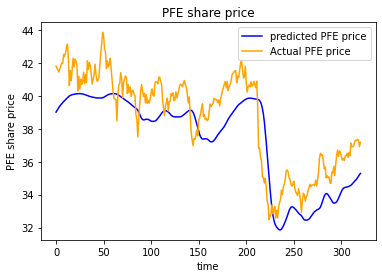

In [31]:
plt.plot(predicted[2050:], color= 'blue',label=f"predicted {company} price")
plt.plot(y_test[2050:], color= 'orange', label=f"Actual {company} price")
plt.rcParams["figure.figsize"] = (6,6)
plt.title(f"{company} share price")
plt.xlabel("time")
plt.ylabel(f"{company} share price")
plt.legend()

In [32]:
real_data = [x_test[len(x_test-1) - window:len(x_test+1),0]]
target_data=[y_test[len(y_test+1) - window:len(y_test+1)]]
real_data = np.array(real_data)
target_data = np.array(target_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 2))
# target_data = np.reshape(target_data, (target_data.shape[0], target_data.shape[1], 1))
display(target_data)
real_data.shape

array([[35.31309128, 35.73054886, 35.15180206, 35.8064537 , 36.36622238,
        36.69829178, 36.32827377, 36.6508522 , 36.54648972, 36.32827377,
        36.10057068, 36.18595886, 36.08159256, 36.32827377, 36.35673523,
        36.50853729, 36.26185989, 36.56546402, 36.36622238, 37.13472366,
        36.90702057, 36.89753342, 36.97343445, 37.22011566, 37.30550385,
        37.27703857, 37.36243057, 37.30550385, 36.91650772, 37.17267609]])

(1, 30, 2)

In [33]:
prediction = model.predict(real_data)
actual_value = load_data(company = 'PFE',
                      start = dt.datetime(2019,12,30),
                      end = dt.datetime(2020,1,3))
print("Closing price prediction for 2020-01-02 ", prediction)
display(actual_value)

Closing price prediction for 2020-01-02  [[33.525234]]


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-30,37.400379,36.897533,37.286530,36.916508,11554264,35.085968
2019-12-31,37.191650,36.726753,36.802658,37.172676,15175703,35.329433
2020-01-02,37.333965,36.888046,37.286530,37.134724,16514072,35.293362
2020-01-03,37.229603,36.688805,36.736244,36.935486,14922848,35.104000
